In [1]:
import sys
print(sys.version)

3.8.5 (v3.8.5:580fbb018f, Jul 20 2020, 12:11:27) 
[Clang 6.0 (clang-600.0.57)]


In [22]:
# Importing dependencies

import numpy as np
np.random.seed(1)
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')

### Data Preprocessing

In [8]:
df = pd.read_csv("Nasdaq100_interpolate.csv",parse_dates = True,index_col=0)
df.head()

,nasdaq100_price,crude_price,GDP,rate_y
Date,,,,
2004-03-22,1381.390015,37.110001,12092.005330,1.01
2004-03-23,1370.040039,37.450001,12094.086297,0.99
2004-03-24,1381.859985,37.009998,12096.167264,0.99
2004-03-25,1425.859985,35.509998,12098.248231,1.02
2004-03-26,1415.390015,35.730000,12100.329198,1.00


In [6]:
df.isnull().sum()

nasdaq100_price      0
crude_price          0
GDP                117
rate_y               0
dtype: int64

In [5]:
# Correlation matrix
df.corr()['nasdaq100_price']

nasdaq100_price    1.000000
crude_price       -0.048172
GDP                0.947350
rate_y             0.100992
Name: nasdaq100_price, dtype: float64

In [9]:
print(df.describe().GDP) 
df.drop(df[df['GDP']==0].index, inplace = True) #Dropping rows with volume value 0

count     4916.000000
mean     18096.023827
std       4042.206975
min      12092.005330
25%      14710.960065
50%      17197.209614
75%      20846.758576
max      27949.457348
Name: GDP, dtype: float64


In [10]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

In [20]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
    
    # Adding Layers to the model
    model = Sequential()
    model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                   activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(LSTM(hl[i],activation = 'relu',return_sequences = True))
    model.add(LSTM(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr), loss='mean_squared_error')
    #print(model.summary())
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']


In [12]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
    #print(X_test.shape,Y_test.shape)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r = r2_score(Y_test,Y_hat)
    return mse, rmse, r, Y_test, Y_hat
  

In [13]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title('Stock Prediction Graph using Multivariate-LSTM model')
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [14]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

### Model Building

In [15]:
# Extracting the series
series = df[['nasdaq100_price','GDP']] # Picking the series with high correlation
print(series.shape)
print(series.tail())

(5033, 2)
            nasdaq100_price  GDP
Date                            
2024-03-13     18068.470703  NaN
2024-03-14     18014.810547  NaN
2024-03-15     17808.250000  NaN
2024-03-18     17985.009766  NaN
2024-03-19     18032.199219  NaN


In [16]:
# Train Val Test Split
train_start = dt.date(1997,1,1)
train_end = dt.date(2006,12,31)
train_data = series.loc[train_start:train_end]

val_start = dt.date(2007,1,1)
val_end = dt.date(2008,12,31)
val_data = series.loc[val_start:val_end]

test_start = dt.date(2009,1,1)
test_end = dt.date(2010,12,31)
test_data = series.loc[test_start:test_end]

print(train_data.shape,val_data.shape,test_data.shape)

(701, 2) (504, 2) (504, 2)


In [17]:
# Normalisation
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(701, 2) (504, 2) (504, 2)


In [18]:
timesteps = 50
hl = [40,35]
lr = 1e-3
batch_size = 64
num_epochs = 250

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


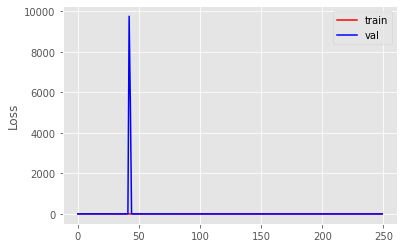

In [23]:
model,train_error,val_error = fit_model(train,val,timesteps,hl,lr,batch_size,num_epochs)
plot_error(train_error,val_error)

MSE = 0.03220311780237938
RMSE = 0.1794522716556672
R-Squared Score = 0.8570292326295417


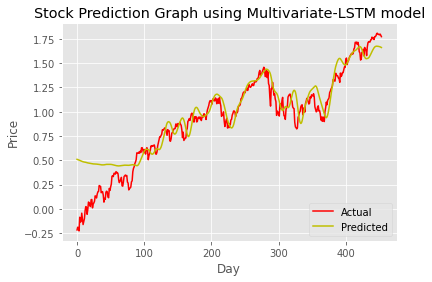

In [24]:
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)

In [26]:
# Save a model
# model.save('multivariate_lstm_model.h5')
#del model # Deletes the model
# Load a model
model = load_model('multivariate_lstm_model.h5')

## Cross-Validation

In [33]:
# Hyperparameters
timesteps = 50
hl = [40,35]
lr = 1e-3
batch_size = 64
num_epochs = 50

In [28]:
# Extracting the series
series = df[['nasdaq100_price','GDP']] # Picking the multivariate series 
print(series.shape)
print(series.tail())

(5033, 2)
            nasdaq100_price  GDP
Date                            
2024-03-13     18068.470703  NaN
2024-03-14     18014.810547  NaN
2024-03-15     17808.250000  NaN
2024-03-18     17985.009766  NaN
2024-03-19     18032.199219  NaN


In [29]:
# Normalisation
sc = MinMaxScaler()
series = sc.fit_transform(series[:5400])
series

array([[1.99740538e-02, 0.00000000e+00],
       [1.93167091e-02, 1.31229597e-04],
       [2.00012726e-02, 2.62459193e-04],
       ...,
       [9.71351286e-01,            nan],
       [9.81588496e-01,            nan],
       [9.84321518e-01,            nan]])

### Split I

In [30]:
#Splitting the data for initial model creation
splits = 5
split_size = 600
train = series[:3*split_size]
test = series[3*split_size:4*split_size]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Split 1
MSE = 0.003090191419208027
RMSE = 0.05558949018661735
R-Squared Score = -11.429415640063679


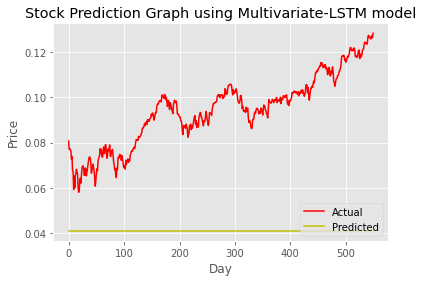

In [36]:
cross_val_results = list()
train_loss = pd.DataFrame()
val_loss = pd.DataFrame()
model,train_error,val_error = fit_model(train,val,timesteps,hl,lr,batch_size,num_epochs)
train_loss['Split1'] = train_error
val_loss['Split1'] = val_error
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 1")
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mse,rmse,r2_value,0])
model.save("MV3-LSTM-Split1.h5")

### Split II

Split 2
MSE = 0.01899208751829945
RMSE = 0.13781178294434568
R-Squared Score = -43.18737935797474


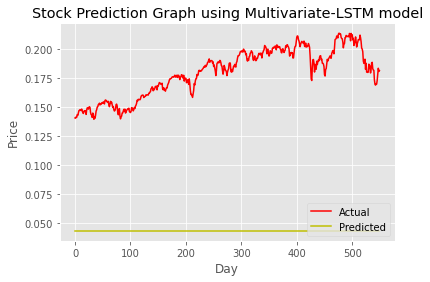

In [37]:

train = series[:4*split_size]
test = series[4*split_size:5*split_size]
X_train,Y_train = [],[]
# Loop for training data
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i][0])
X_train,Y_train = np.array(X_train),np.array(Y_train)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split2"] = history.history['loss']
val_loss["Split2"] = history.history['val_loss']
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 2")
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mse,rmse,r2_value,end-start])
model.save("MV3-LSTM-Split2.h5")

### Split III

Split 3
MSE = 0.04853334446241541
RMSE = 0.22030284715004345
R-Squared Score = -19.132631025040062


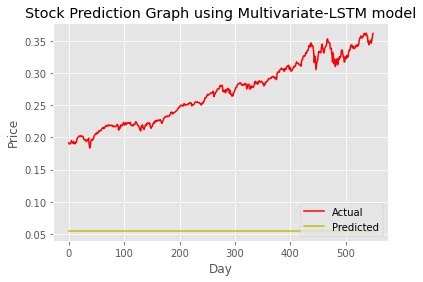

In [38]:
train = series[:5*split_size]
test = series[5*split_size:6*split_size]
X_train,Y_train = [],[]
# Loop for training data
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i][0])
X_train,Y_train = np.array(X_train),np.array(Y_train)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split3"] = history.history['loss']
val_loss["Split3"] = history.history['val_loss']
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 3")
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mse,rmse,r2_value,end-start])
model.save("MV3-LSTM-Split3.h5")

### Split IV

Split 4
MSE = 0.1360663388540759
RMSE = 0.36887171056354523
R-Squared Score = -15.129671598080652


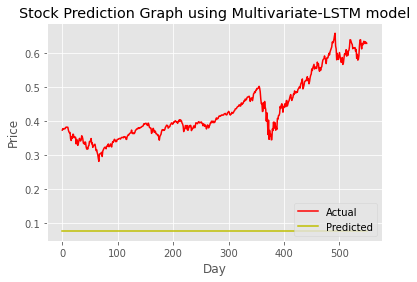

In [39]:
train = series[:6*split_size]
test = series[6*split_size:7*split_size]
X_train,Y_train = [],[]
# Loop for training data
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i][0])
X_train,Y_train = np.array(X_train),np.array(Y_train)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split4"] = history.history['loss']
val_loss["Split4"] = history.history['val_loss']
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 4")
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mse,rmse,r2_value,end-start])
model.save("MV3-LSTM-Split4.h5")

### Split V

Split 5
MSE = 0.3943145116240806
RMSE = 0.6279446724227228
R-Squared Score = -47.681948182672095


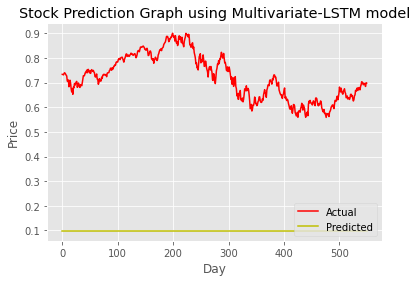

In [40]:
train = series[:7*split_size]
test = series[7*split_size:8*split_size]
X_train,Y_train = [],[]
# Loop for training data
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i][0])
X_train,Y_train = np.array(X_train),np.array(Y_train)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split5"] = history.history['loss']
val_loss["Split5"] = history.history['val_loss']
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 5")
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mse,rmse,r2_value,end-start])
model.save("MV3-LSTM-Split5.h5")

In [41]:
CV_results = pd.DataFrame(cross_val_results,columns=['MSE','RMSE','R2_Score','Train_Time'])
print("Avg. MSE = {}".format(CV_results['MSE'].mean()))
print("Avg. RMSE = {}".format(CV_results['RMSE'].mean()))
print("Avg. R2-score = {}".format(CV_results['R2_Score'].mean()))

Avg. MSE = 0.12019929477561589
Avg. RMSE = 0.2821041006534549
Avg. R2-score = -27.312209160766248


In [44]:
CV_results.to_csv('MV3-LSTM_CrossValidation.csv')
train_loss.to_csv('MV3-LSTM_CrossValidation_TrainLoss.csv')
val_loss.to_csv('MV3-LSTM_CrossValidation_ValLoss.csv')